In [7]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from wmfdata import charting, hive
%matplotlib inline
charting.set_mpl_style()

In [7]:
## If running this from a vanilla installation, issues with the versions of thrift and impyla
## are likely to occur. Therefore, install these specific versions:
## !pip uninstall -y thrift
## !pip uninstall -y impyla
## !pip uninstall -y thrift-sasl
## !pip install thrift-sasl==0.2.1
## !pip install thrift==0.9.3
## !pip install impyla==0.13.8

Uninstalling thrift-0.11.0:
  Successfully uninstalled thrift-0.11.0
Uninstalling impyla-0.13.8:
  Successfully uninstalled impyla-0.13.8
Uninstalling thrift-sasl-0.3.0:
  Successfully uninstalled thrift-sasl-0.3.0
  Running setup.py bdist_wheel for thrift-sasl ... done
  Stored in directory: /home/nettrom/.cache/pip/wheels/0a/a5/1c/8e41c12939d17289bb44d076095533322e9a1e370d0608117b
Successfully built thrift-sasl


In [2]:
# UPDATE FOR NEW MONTH! Start included, end excluded.
# Have to set the end back a couple of months to ensure we only get uncensored data.
# To-do: We take the metric month and look backwards. But this results in censored data
# for months under 30 days (February).
START = "2018-09"
END = "2018-10"
MWH_SNAPSHOT = "2018-11" # The latest available mediawiki_history snapshot

# Update table

In [3]:
# Create the table if necessary
hive.run(
"""
create table if not exists neilpquinn.new_editors (
    user_name string,
    wiki string,
    user_id bigint,
    cohort string,
    1st_month_edits bigint,
    2nd_month_edits bigint
)
-- This allows us to delete data later on (e.g. in case of duplicate inserts)
TBLPROPERTIES ("transactional"="true")
"""
)

# Select and insert the new data. Be careful not to insert duplicate data. Primary 
# keys were introduced in Hive 2.1.0, so until we're running that there's no built-in 
# way to stop duplicates.
hive.run(
"""
insert into table neilpquinn.new_editors
select 
    1st_month.user_name as user_name,
    1st_month.wiki as wiki,
    1st_month.user_id as user_id,
    1st_month.cohort as cohort,
    1st_month.edits as 1st_month_edits,
    coalesce(2nd_month.edits, 0) as 2nd_month_edits
from (
    select
        event_user_text as user_name,
        wiki_db as wiki,
        event_user_id as user_id,
        substr(event_user_creation_timestamp, 0, 7) as cohort,
        count(*) as edits
    from wmf.mediawiki_history
    where
        snapshot = "{snapshot}" and
        event_entity = "revision" and
        event_type = "create" and
        not event_user_is_created_by_system and
        event_user_creation_timestamp between "{start}" and "{end}" and
        unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
            (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
    group by event_user_text, event_user_id, event_user_creation_timestamp, wiki_db
    ) 1st_month
left join (
    select
        event_user_text as user_name,
        wiki_db as wiki,
        event_user_id as user_id,
        substr(event_user_creation_timestamp, 0, 7) as cohort,
        count(*) as edits
    from wmf.mediawiki_history
    where
        snapshot = "{snapshot}" and
        event_entity = "revision" and
        event_type = "create" and
        not event_user_is_created_by_system and
        event_user_creation_timestamp between "{start}" and "{end}" and
        unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") >=
            (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60)) and
        unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
            (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (60*24*60*60))
        group by event_user_text, event_user_id, event_user_creation_timestamp, wiki_db
    ) 2nd_month
on
    (1st_month.user_name = 2nd_month.user_name and
    1st_month.wiki = 2nd_month.wiki and
    1st_month.cohort = 2nd_month.cohort)
""".format(
    snapshot = MWH_SNAPSHOT,
    start = START,
    end = END
))

# Validate

In [4]:
hive.run("""
select count(*) from neilpquinn.new_editors
""")

,_c0
0,18127251


In [5]:
# Check the monthly number of rows (i.e. new editors) from four wikis to check for duplicated data.
new_editors = hive.run(
"""
select wiki, cohort, count(*) as new_editors
from neilpquinn.new_editors
where wiki in ("arwiki", "enwiki", "jawiki", "zhwiki")
group by wiki, cohort
order by wiki, cohort asc
limit 10000
"""
)

new_editors = (
    new_editors
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
    .set_index("cohort")
    .pivot(columns="wiki")
    .xs("new_editors", axis=1)
)
    
new_editors.tail()

wiki,arwiki,enwiki,jawiki,zhwiki
cohort,,,,
2018-05-01,2508.0,46215.0,3219.0,1940.0
2018-06-01,2288.0,41197.0,2892.0,1721.0
2018-07-01,2463.0,41365.0,3221.0,2024.0
2018-08-01,2732.0,43746.0,3140.0,2109.0
2018-09-01,3283.0,46496.0,2996.0,1620.0


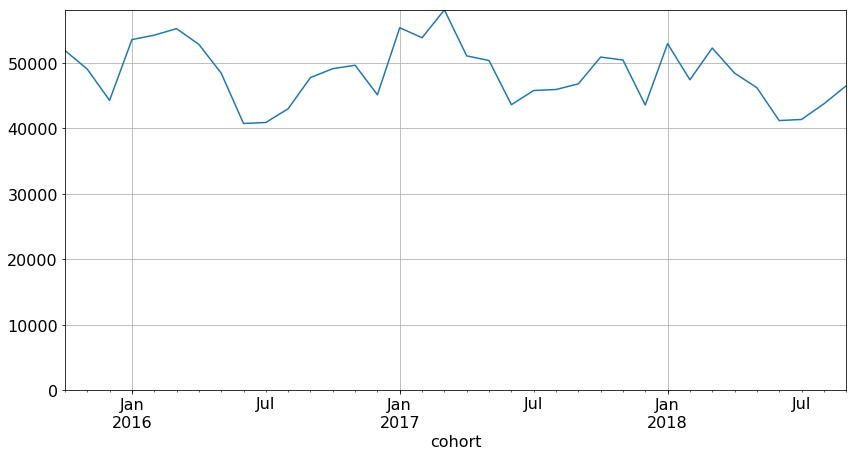

In [8]:
new_editors.loc["2015-10":, "enwiki"].plot()
plt.ylim(0);

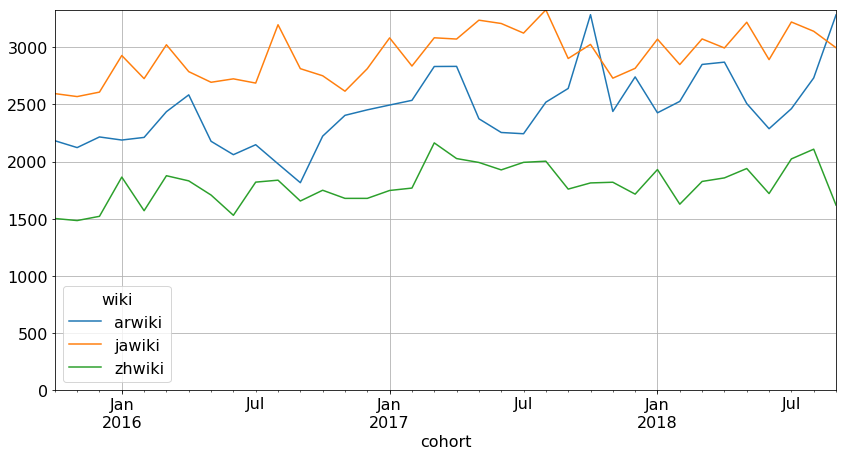

In [9]:
new_editors.loc["2015-10":, ["arwiki", "jawiki", "zhwiki"]].plot()
plt.ylim(0);